# Notebook 03: Type-Attribute Correlation Analysis

**Objective**: Discover patterns in type and attribute combinations in the Digimon Knowledge Graph.

This notebook explores:
- Distribution analysis of types and attributes by level
- Statistical correlation studies between features
- Pattern mining for frequent combinations
- Predictive analysis of type-attribute relationships

---

## 1. Setup and Imports

In [22]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Custom utilities
from utils import (
    Neo4jConnector, 
    plot_heatmap, save_figure,
    TYPE_COLORS, ATTRIBUTE_COLORS, LEVEL_COLORS
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

# Set notebook name for organized output
notebook_name = "03_type_attribute_correlation"

print("Environment setup complete!")

Environment setup complete!


## 2. Load Data

In [23]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Get all Digimon data
digimon_df = conn.get_all_digimon()
print(f"\nLoaded {len(digimon_df)} Digimon records")

# Remove any records with missing type/attribute/level
complete_df = digimon_df.dropna(subset=['type', 'attribute', 'level'])
print(f"Complete records (no missing values): {len(complete_df)}")

# Display sample
complete_df[['name_en', 'level', 'type', 'attribute']].head(10)

Connected to Neo4j database

Loaded 1258 Digimon records
Complete records (no missing values): 1249


,name_en,level,type,attribute
0,ABBADOMON,Mega,Tribe unknown Species,Unknown
1,ABBADOMONCORE,Mega,Tribe unknown Species,Unknown
2,ACHILLESMON,Mega,Beastman Type,Virus
3,AEGIOCHUSMON,Ultimate,God Type,Vaccine
4,AEGIOCHUSMON:BLUE,Ultimate,God Type,Vaccine
5,AEGIOCHUSMON:DARK,Ultimate,God Type,Vaccine
6,AEGIOCHUSMON:GREEN,Ultimate,God Type,Vaccine
7,AEGIOCHUSMON_HOLLY,Ultimate,God Type,Vaccine
8,AEGIOMON,Champion,God Type,Vaccine
9,AGEISDRAMON,Mega,cyborg Type,Vaccine


## 3. Distribution Analysis

In [24]:
# Type frequency by level
type_by_level = pd.crosstab(complete_df['level'], complete_df['type'])

# Order levels properly
level_order = ['Baby', 'In-Training', 'Rookie', 'Champion', 'Ultimate', 'Mega', 'Ultra']
type_by_level = type_by_level.reindex(level_order, fill_value=0)

print("=== TYPE DISTRIBUTION BY LEVEL ===")
print(type_by_level.head(10))  # Show first 10 types
print(f"\nTotal unique types: {type_by_level.shape[1]}")

=== TYPE DISTRIBUTION BY LEVEL ===
type         9000 Type  Aliens Type  Amphibians Type  Ancient Beast Type  \
level                                                                      
Baby                 0            0                0                   0   
In-Training          0            0                0                   0   
Rookie               0            0                5                   0   
Champion             0            0                1                   0   
Ultimate             0            2                1                   2   
Mega                 1            0                0                   4   
Ultra                0            0                0                   0   

type         Ancient Birdman Type  Ancient Crustaceans Type  \
level                                                         
Baby                            0                         0   
In-Training                     0                         0   
Rookie                      

In [25]:
# Attribute distribution by type (top 15 types)
top_types = complete_df['type'].value_counts().head(15).index
attr_by_type = pd.crosstab(
    complete_df[complete_df['type'].isin(top_types)]['type'],
    complete_df[complete_df['type'].isin(top_types)]['attribute']
)

print("=== ATTRIBUTE DISTRIBUTION BY TOP TYPES ===")
print(attr_by_type)

=== ATTRIBUTE DISTRIBUTION BY TOP TYPES ===
attribute             Data  Free  Unknown  Vaccine  Variable  Virus
type                                                               
Beastman Type      0     9     2        0       18         2      7
Demon Type         0     9     5        0        3         4     18
Dragon Type        0     5     2        0        8         0     12
God Type           0     9     0        0       20         0      9
Holy Beast Type    0     7     2        0       18         0      4
Holy Knight Type   0    12     1        0       14         0      8
Lesser Type       30     0     0        0        0         0      0
Machine Type       2    11     2        0       11         0     15
Puppet Type        0    14     1        0        8         0     25
Slime Type        35     0     0        0        0         0      0
beast Type         0    12     5        0       15         1      6
cyborg Type        0    25     3        0       22         8     40
dino

In [26]:
[]# Create type-attribute combination frequency
type_attr_combinations = complete_df.groupby(['type', 'attribute']).size().reset_index(name='count')
type_attr_combinations = type_attr_combinations.sort_values('count', ascending=False)

print("=== MOST COMMON TYPE-ATTRIBUTE COMBINATIONS ===")
print(type_attr_combinations.head(20))

# Rare combinations
rare_combinations = type_attr_combinations[type_attr_combinations['count'] == 1]
print(f"\nNumber of unique (rare) combinations: {len(rare_combinations)}")
print("\nExample rare combinations:")
print(rare_combinations.head(10))

=== MOST COMMON TYPE-ATTRIBUTE COMBINATIONS ===
                 type attribute  count
229       cyborg Type     Virus     40
179        Slime Type               35
132       Lesser Type               30
225       cyborg Type      Data     25
166       Puppet Type     Virus     25
227       cyborg Type   Vaccine     22
273     mutation Type      Data     22
109          God Type   Vaccine     20
77    Demon King Type     Virus     20
72   Demon Beast Type     Virus     19
113   Holy Beast Type   Vaccine     18
82         Demon Type     Virus     18
202       Undead Type     Virus     18
48      Beastman Type   Vaccine     18
278     mutation Type     Virus     17
217        beast Type   Vaccine     15
145      Machine Type     Virus     15
119  Holy Knight Type   Vaccine     14
163       Puppet Type      Data     14
204           Unknown   Unknown     14

Number of unique (rare) combinations: 112

Example rare combinations:
                        type attribute  count
263             

## 4. Statistical Correlation Analysis

In [27]:
# Chi-square test for independence between type and attribute
contingency_table = pd.crosstab(complete_df['type'], complete_df['attribute'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("=== CHI-SQUARE TEST: Type vs Attribute ===")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\nResult: Type and Attribute are DEPENDENT (p < 0.05)")
else:
    print("\nResult: Type and Attribute are INDEPENDENT (p >= 0.05)")

=== CHI-SQUARE TEST: Type vs Attribute ===
Chi-square statistic: 3865.27
p-value: 0.00e+00
Degrees of freedom: 973

Result: Type and Attribute are DEPENDENT (p < 0.05)


In [28]:
# Calculate Cramér's V for effect size
def cramers_v(confusion_matrix):
    try:
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        # Handle edge cases
        if n == 0 or min(r, k) <= 1:
            return 0.0
        return np.sqrt(chi2 / (n * (min(r, k) - 1)))
    except ValueError:
        # Return 0 if chi-square test fails
        return 0.0

cramers_v_value = cramers_v(contingency_table)
print(f"\nCramér's V (effect size): {cramers_v_value:.3f}")

# Interpretation
if cramers_v_value < 0.1:
    effect = "negligible"
elif cramers_v_value < 0.3:
    effect = "small"
elif cramers_v_value < 0.5:
    effect = "medium"
else:
    effect = "large"

print(f"Effect size interpretation: {effect}")


Cramér's V (effect size): 0.665
Effect size interpretation: large


In [29]:
# Mutual Information between type and attribute
le_type = LabelEncoder()
le_attr = LabelEncoder()

type_encoded = le_type.fit_transform(complete_df['type'])
attr_encoded = le_attr.fit_transform(complete_df['attribute'])

mi_score = mutual_info_score(type_encoded, attr_encoded)
print(f"\nMutual Information Score: {mi_score:.3f}")

# Normalized MI (0 to 1)
from sklearn.metrics import normalized_mutual_info_score
nmi_score = normalized_mutual_info_score(type_encoded, attr_encoded)
print(f"Normalized Mutual Information: {nmi_score:.3f}")


Mutual Information Score: 0.688
Normalized Mutual Information: 0.237


In [30]:
# Test associations for each level separately
print("\n=== CHI-SQUARE TESTS BY LEVEL ===")
level_associations = []

for level in level_order:
    level_data = complete_df[complete_df['level'] == level]
    if len(level_data) > 20:  # Only test if sufficient data
        cont_table = pd.crosstab(level_data['type'], level_data['attribute'])
        # Remove types/attributes with very low counts
        cont_table = cont_table.loc[(cont_table.sum(axis=1) > 2), (cont_table.sum(axis=0) > 2)]
        
        if cont_table.shape[0] > 1 and cont_table.shape[1] > 1:
            try:
                # Check if any cells would have expected frequency < 5
                row_totals = cont_table.sum(axis=1)
                col_totals = cont_table.sum(axis=0)
                total = cont_table.sum().sum()
                
                # Calculate minimum expected frequency
                min_expected = float('inf')
                for i in range(len(row_totals)):
                    for j in range(len(col_totals)):
                        expected = (row_totals.iloc[i] * col_totals.iloc[j]) / total
                        if expected < min_expected:
                            min_expected = expected
                
                # Only perform test if minimum expected frequency is reasonable
                if min_expected >= 1:
                    chi2, p_value, _, _ = chi2_contingency(cont_table)
                    cramers_v_val = cramers_v(cont_table)
                    
                    level_associations.append({
                        'level': level,
                        'n_digimon': len(level_data),
                        'chi2': chi2,
                        'p_value': p_value,
                        'cramers_v': cramers_v_val
                    })
                    
                    print(f"\n{level}:")
                    print(f"  N = {len(level_data)}")
                    print(f"  Chi² = {chi2:.2f}, p = {p_value:.3f}")
                    print(f"  Cramér's V = {cramers_v_val:.3f}")
                else:
                    print(f"\n{level}: Skipped (expected frequencies too low)")
                    
            except ValueError as e:
                print(f"\n{level}: Skipped due to error: {str(e)}")
                continue

level_assoc_df = pd.DataFrame(level_associations)


=== CHI-SQUARE TESTS BY LEVEL ===

Rookie: Skipped (expected frequencies too low)

Champion: Skipped (expected frequencies too low)

Ultimate: Skipped (expected frequencies too low)

Mega: Skipped (expected frequencies too low)


## 5. Pattern Mining

In [31]:
# Prepare data for association rule mining
# Create transactions with type, attribute, and level
transactions = []
for _, row in complete_df.iterrows():
    transaction = [
        f"type:{row['type']}",
        f"attr:{row['attribute']}",
        f"level:{row['level']}"
    ]
    transactions.append(transaction)

# Convert to one-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction dataset shape: {transaction_df.shape}")
print(f"Number of features: {len(te.columns_)}")

Transaction dataset shape: (1249, 163)
Number of features: 163


In [32]:
# Find frequent itemsets
min_support = 0.05  # At least 5% of Digimon
frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print(f"=== FREQUENT ITEMSETS (min support = {min_support}) ===")
print(f"Found {len(frequent_itemsets)} frequent itemsets\n")

# Filter for interesting combinations (2+ items)
interesting_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) >= 2)]
print("Top frequent combinations:")
for idx, row in interesting_itemsets.head(20).iterrows():
    items = list(row['itemsets'])
    support = row['support']
    print(f"  {' + '.join(items)}: {support:.3f} ({support*100:.1f}%)")

=== FREQUENT ITEMSETS (min support = 0.05) ===
Found 20 frequent itemsets

Top frequent combinations:
  attr:Virus + level:Mega: 0.099 (9.9%)
  attr:Vaccine + level:Mega: 0.079 (7.9%)
  attr:Virus + level:Ultimate: 0.076 (7.6%)
  level:Champion + attr:Virus: 0.074 (7.4%)
  level:Mega + attr:Data: 0.066 (6.6%)
  level:Champion + attr:Data: 0.062 (6.2%)
  attr:Vaccine + level:Ultimate: 0.060 (6.0%)
  level:Ultimate + attr:Data: 0.055 (5.5%)
  level:Champion + attr:Vaccine: 0.050 (5.0%)


In [33]:
# Generate association rules
if len(frequent_itemsets) > 0:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    rules = rules.sort_values('lift', ascending=False)
    
    print("\n=== TOP ASSOCIATION RULES ===")
    print(f"Found {len(rules)} rules with confidence >= 0.7\n")
    
    # Display top rules
    for idx, rule in rules.head(15).iterrows():
        antecedents = ', '.join(list(rule['antecedents']))
        consequents = ', '.join(list(rule['consequents']))
        confidence = rule['confidence']
        lift = rule['lift']
        
        print(f"Rule {idx+1}: {antecedents} → {consequents}")
        print(f"  Confidence: {confidence:.3f}, Lift: {lift:.3f}")
        print()


=== TOP ASSOCIATION RULES ===
Found 0 rules with confidence >= 0.7



## 6. Predictive Analysis

In [34]:
# Analyze if we can predict attribute from type
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare data
le_type = LabelEncoder()
le_attr = LabelEncoder()

X = le_type.fit_transform(complete_df['type']).reshape(-1, 1)
y = le_attr.fit_transform(complete_df['attribute'])

# Simple model to test predictability
rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print("=== ATTRIBUTE PREDICTABILITY FROM TYPE ===")
print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
print(f"Baseline accuracy (most common class): {complete_df['attribute'].value_counts().max() / len(complete_df):.3f}")

# Fit the model to get feature importance
rf.fit(X, y)
print(f"\nModel improvement over baseline: {scores.mean() - (complete_df['attribute'].value_counts().max() / len(complete_df)):.3f}")

=== ATTRIBUTE PREDICTABILITY FROM TYPE ===
Cross-validation accuracy: 0.480 (+/- 0.037)
Baseline accuracy (most common class): 0.318

Model improvement over baseline: 0.163


In [35]:
# Analyze type clustering based on attribute distribution
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create type-attribute matrix for clustering
type_attr_matrix = pd.crosstab(complete_df['type'], complete_df['attribute'])
type_attr_matrix_norm = type_attr_matrix.div(type_attr_matrix.sum(axis=1), axis=0)

# Filter to types with at least 5 Digimon
type_counts = complete_df['type'].value_counts()
common_types = type_counts[type_counts >= 5].index
type_attr_matrix_norm = type_attr_matrix_norm.loc[common_types]

# Perform clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
type_clusters = kmeans.fit_predict(type_attr_matrix_norm)

# Create cluster results
cluster_df = pd.DataFrame({
    'type': type_attr_matrix_norm.index,
    'cluster': type_clusters
})

print(f"=== TYPE CLUSTERING BASED ON ATTRIBUTES ===")
print(f"Clustered {len(common_types)} types into {n_clusters} groups\n")

for cluster_id in range(n_clusters):
    cluster_types = cluster_df[cluster_df['cluster'] == cluster_id]['type'].tolist()
    print(f"Cluster {cluster_id + 1} ({len(cluster_types)} types):")
    print(f"  {', '.join(cluster_types[:10])}{'...' if len(cluster_types) > 10 else ''}")
    
    # Show dominant attribute pattern
    cluster_data = complete_df[complete_df['type'].isin(cluster_types)]
    attr_dist = cluster_data['attribute'].value_counts(normalize=True)
    print(f"  Attribute distribution: {dict(attr_dist)}")
    print()

=== TYPE CLUSTERING BASED ON ATTRIBUTES ===
Clustered 58 types into 5 groups

Cluster 1 (20 types):
  beast Type, Beastman Type, God Type, Holy Knight Type, Holy Beast Type, dinosaur Type, mammalian Type, bird Type, Warrior Type, Giant bird Type...
  Attribute distribution: {'Vaccine': 0.4551083591331269, 'Data': 0.24458204334365324, 'Virus': 0.16718266253869968, 'Free': 0.09287925696594428, 'Variable': 0.02786377708978328, '': 0.009287925696594427, 'Unknown': 0.0030959752321981426}

Cluster 2 (23 types):
  cyborg Type, Puppet Type, Machine Type, insect Type, Demon Type, Dragon Type, plant Type, Demon Beast Type, Demon King Type, Undead Type...
  Attribute distribution: {'Virus': 0.5283757338551859, 'Data': 0.2172211350293542, 'Vaccine': 0.14481409001956946, 'Free': 0.06457925636007827, 'Variable': 0.033268101761252444, '': 0.011741682974559686}

Cluster 3 (2 types):
  Slime Type, Lesser Type
  Attribute distribution: {'': 1.0}

Cluster 4 (2 types):
  Tribe unknown Species, Unknown
  A

## 7. Visualizations

Saved: ../results/03_type_attribute_correlation/figures/type_attribute_heatmap.png
Saved: ../results/03_type_attribute_correlation/figures/type_attribute_heatmap.svg
Saved: ../results/03_type_attribute_correlation/figures/type_attribute_heatmap.pdf


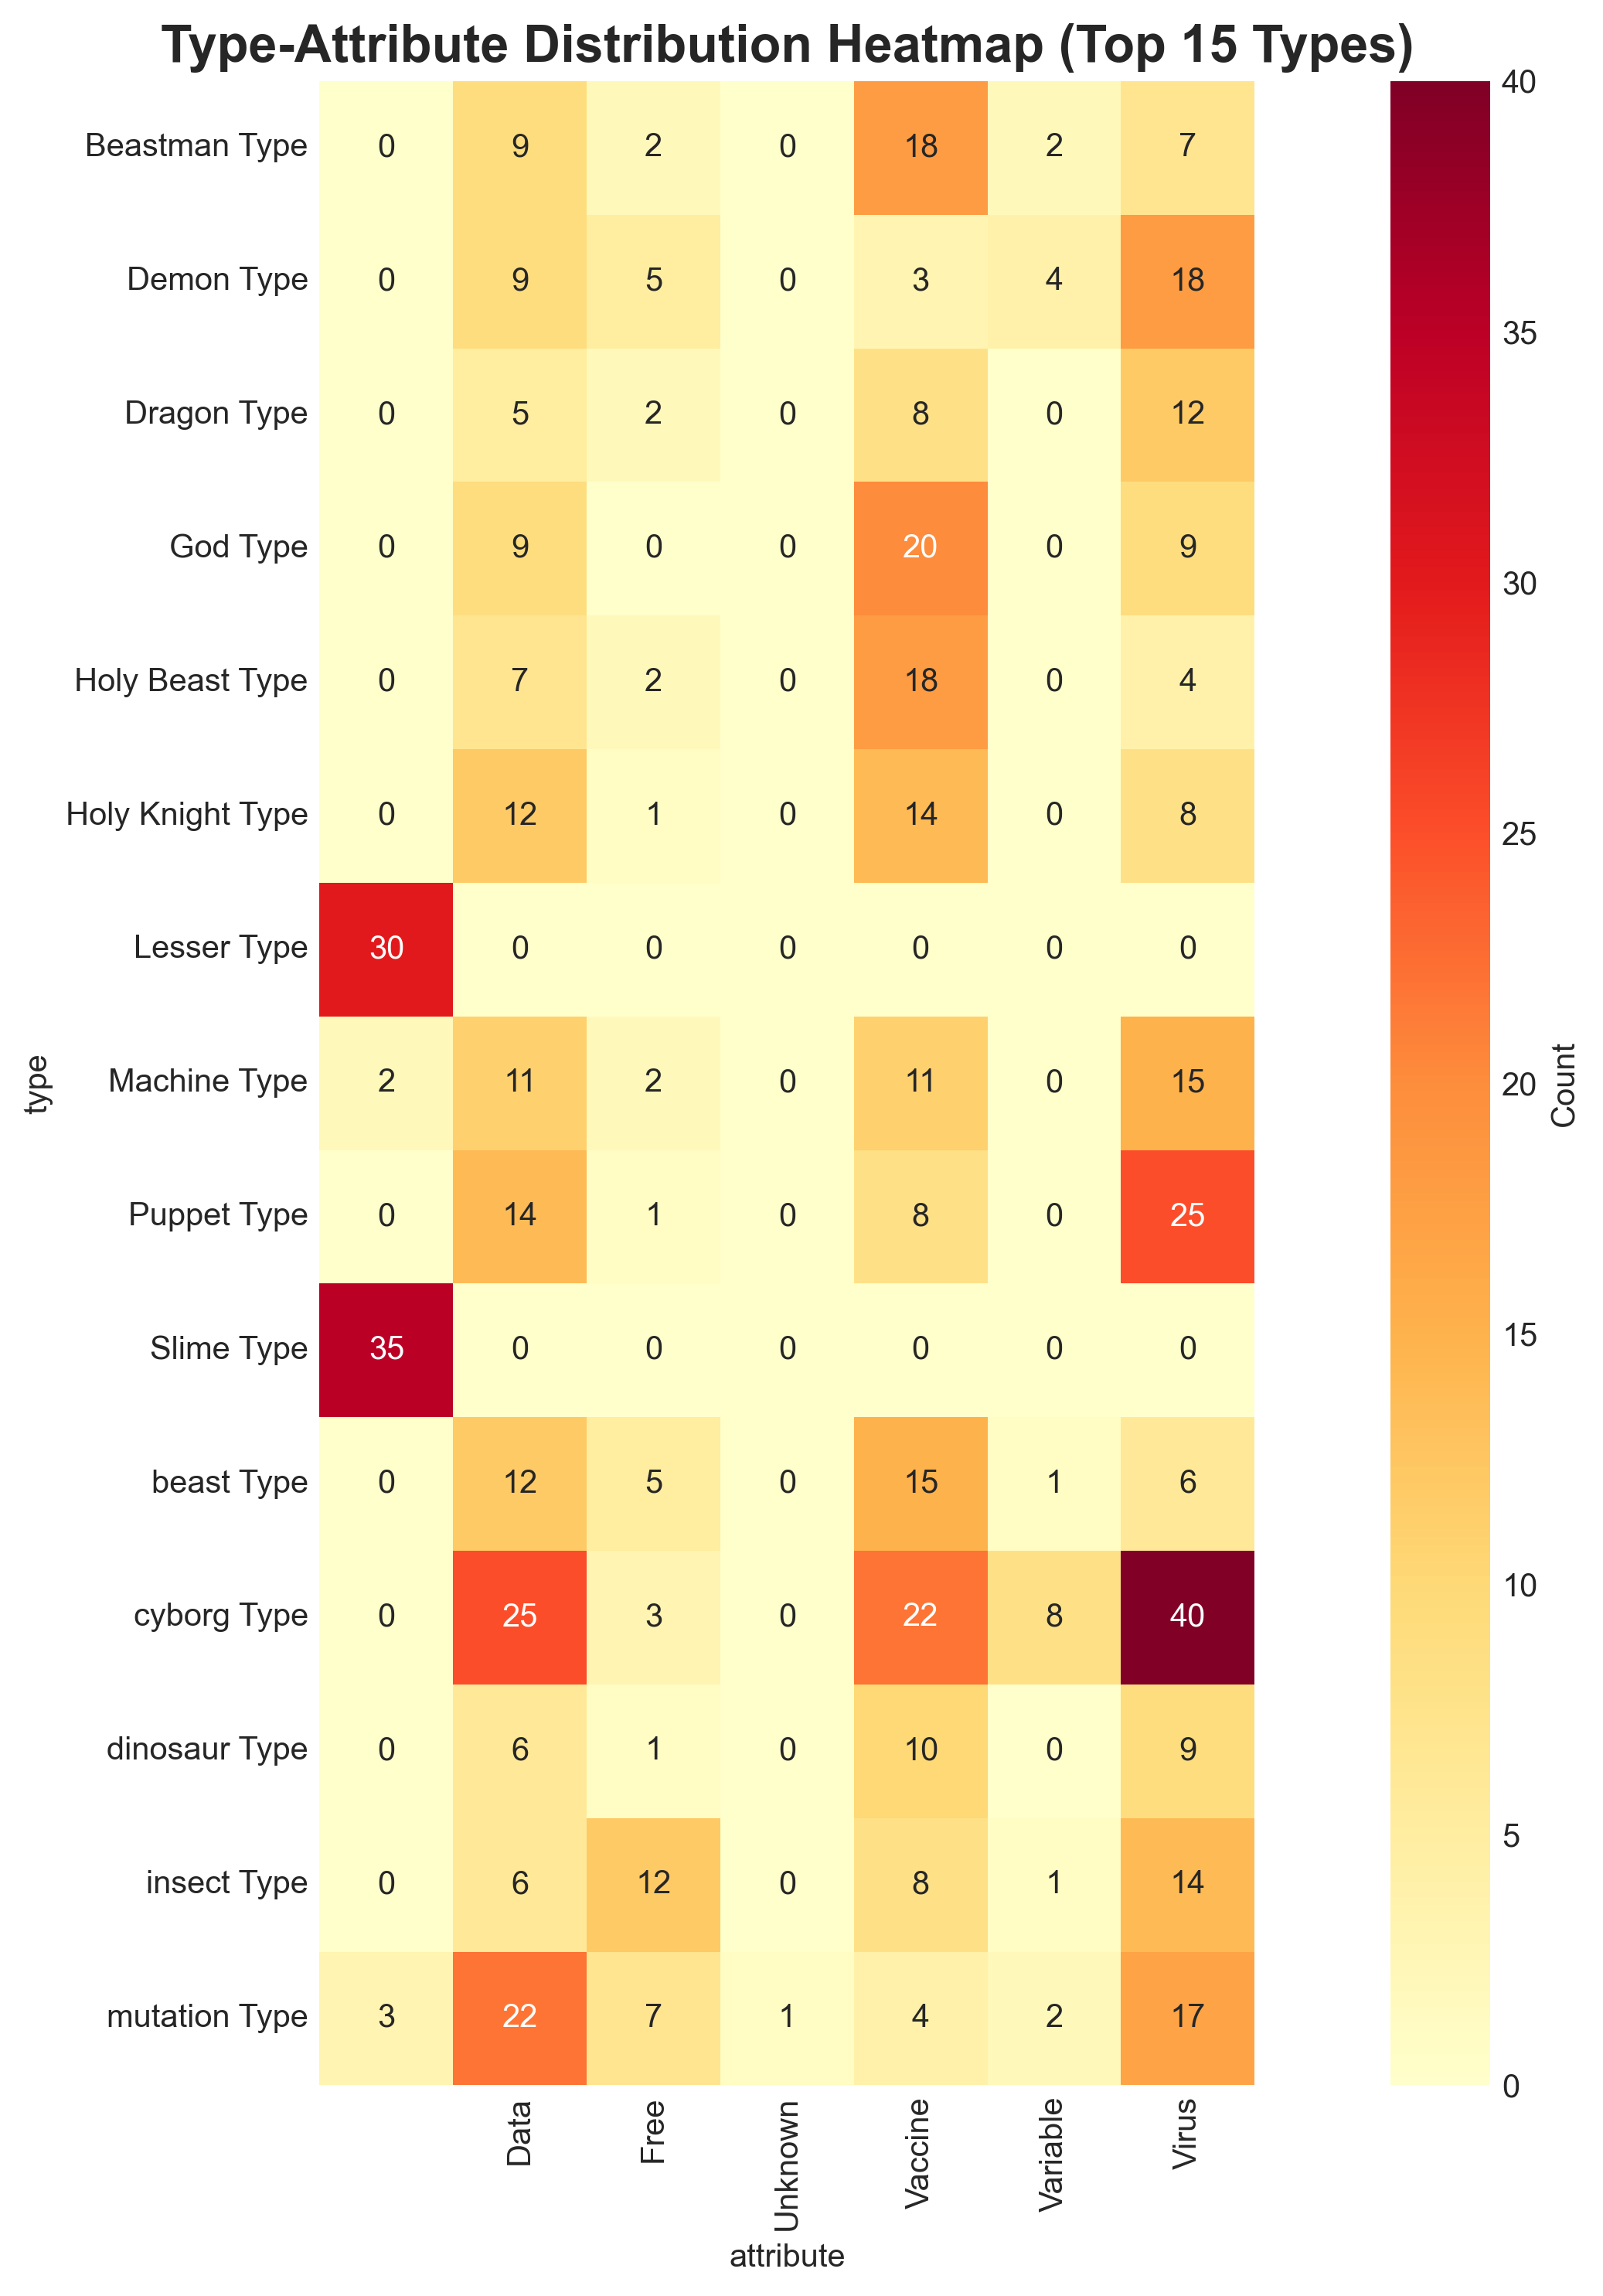

In [36]:
# Type-Attribute heatmap (top types)
fig = plot_heatmap(
    attr_by_type,
    title="Type-Attribute Distribution Heatmap (Top 15 Types)",
    figsize=(12, 10)
)
save_figure(fig, "type_attribute_heatmap", notebook_name=notebook_name)
plt.show()

Saved: ../results/03_type_attribute_correlation/figures/type_attribute_bubble_chart.png
Saved: ../results/03_type_attribute_correlation/figures/type_attribute_bubble_chart.svg
Saved: ../results/03_type_attribute_correlation/figures/type_attribute_bubble_chart.pdf


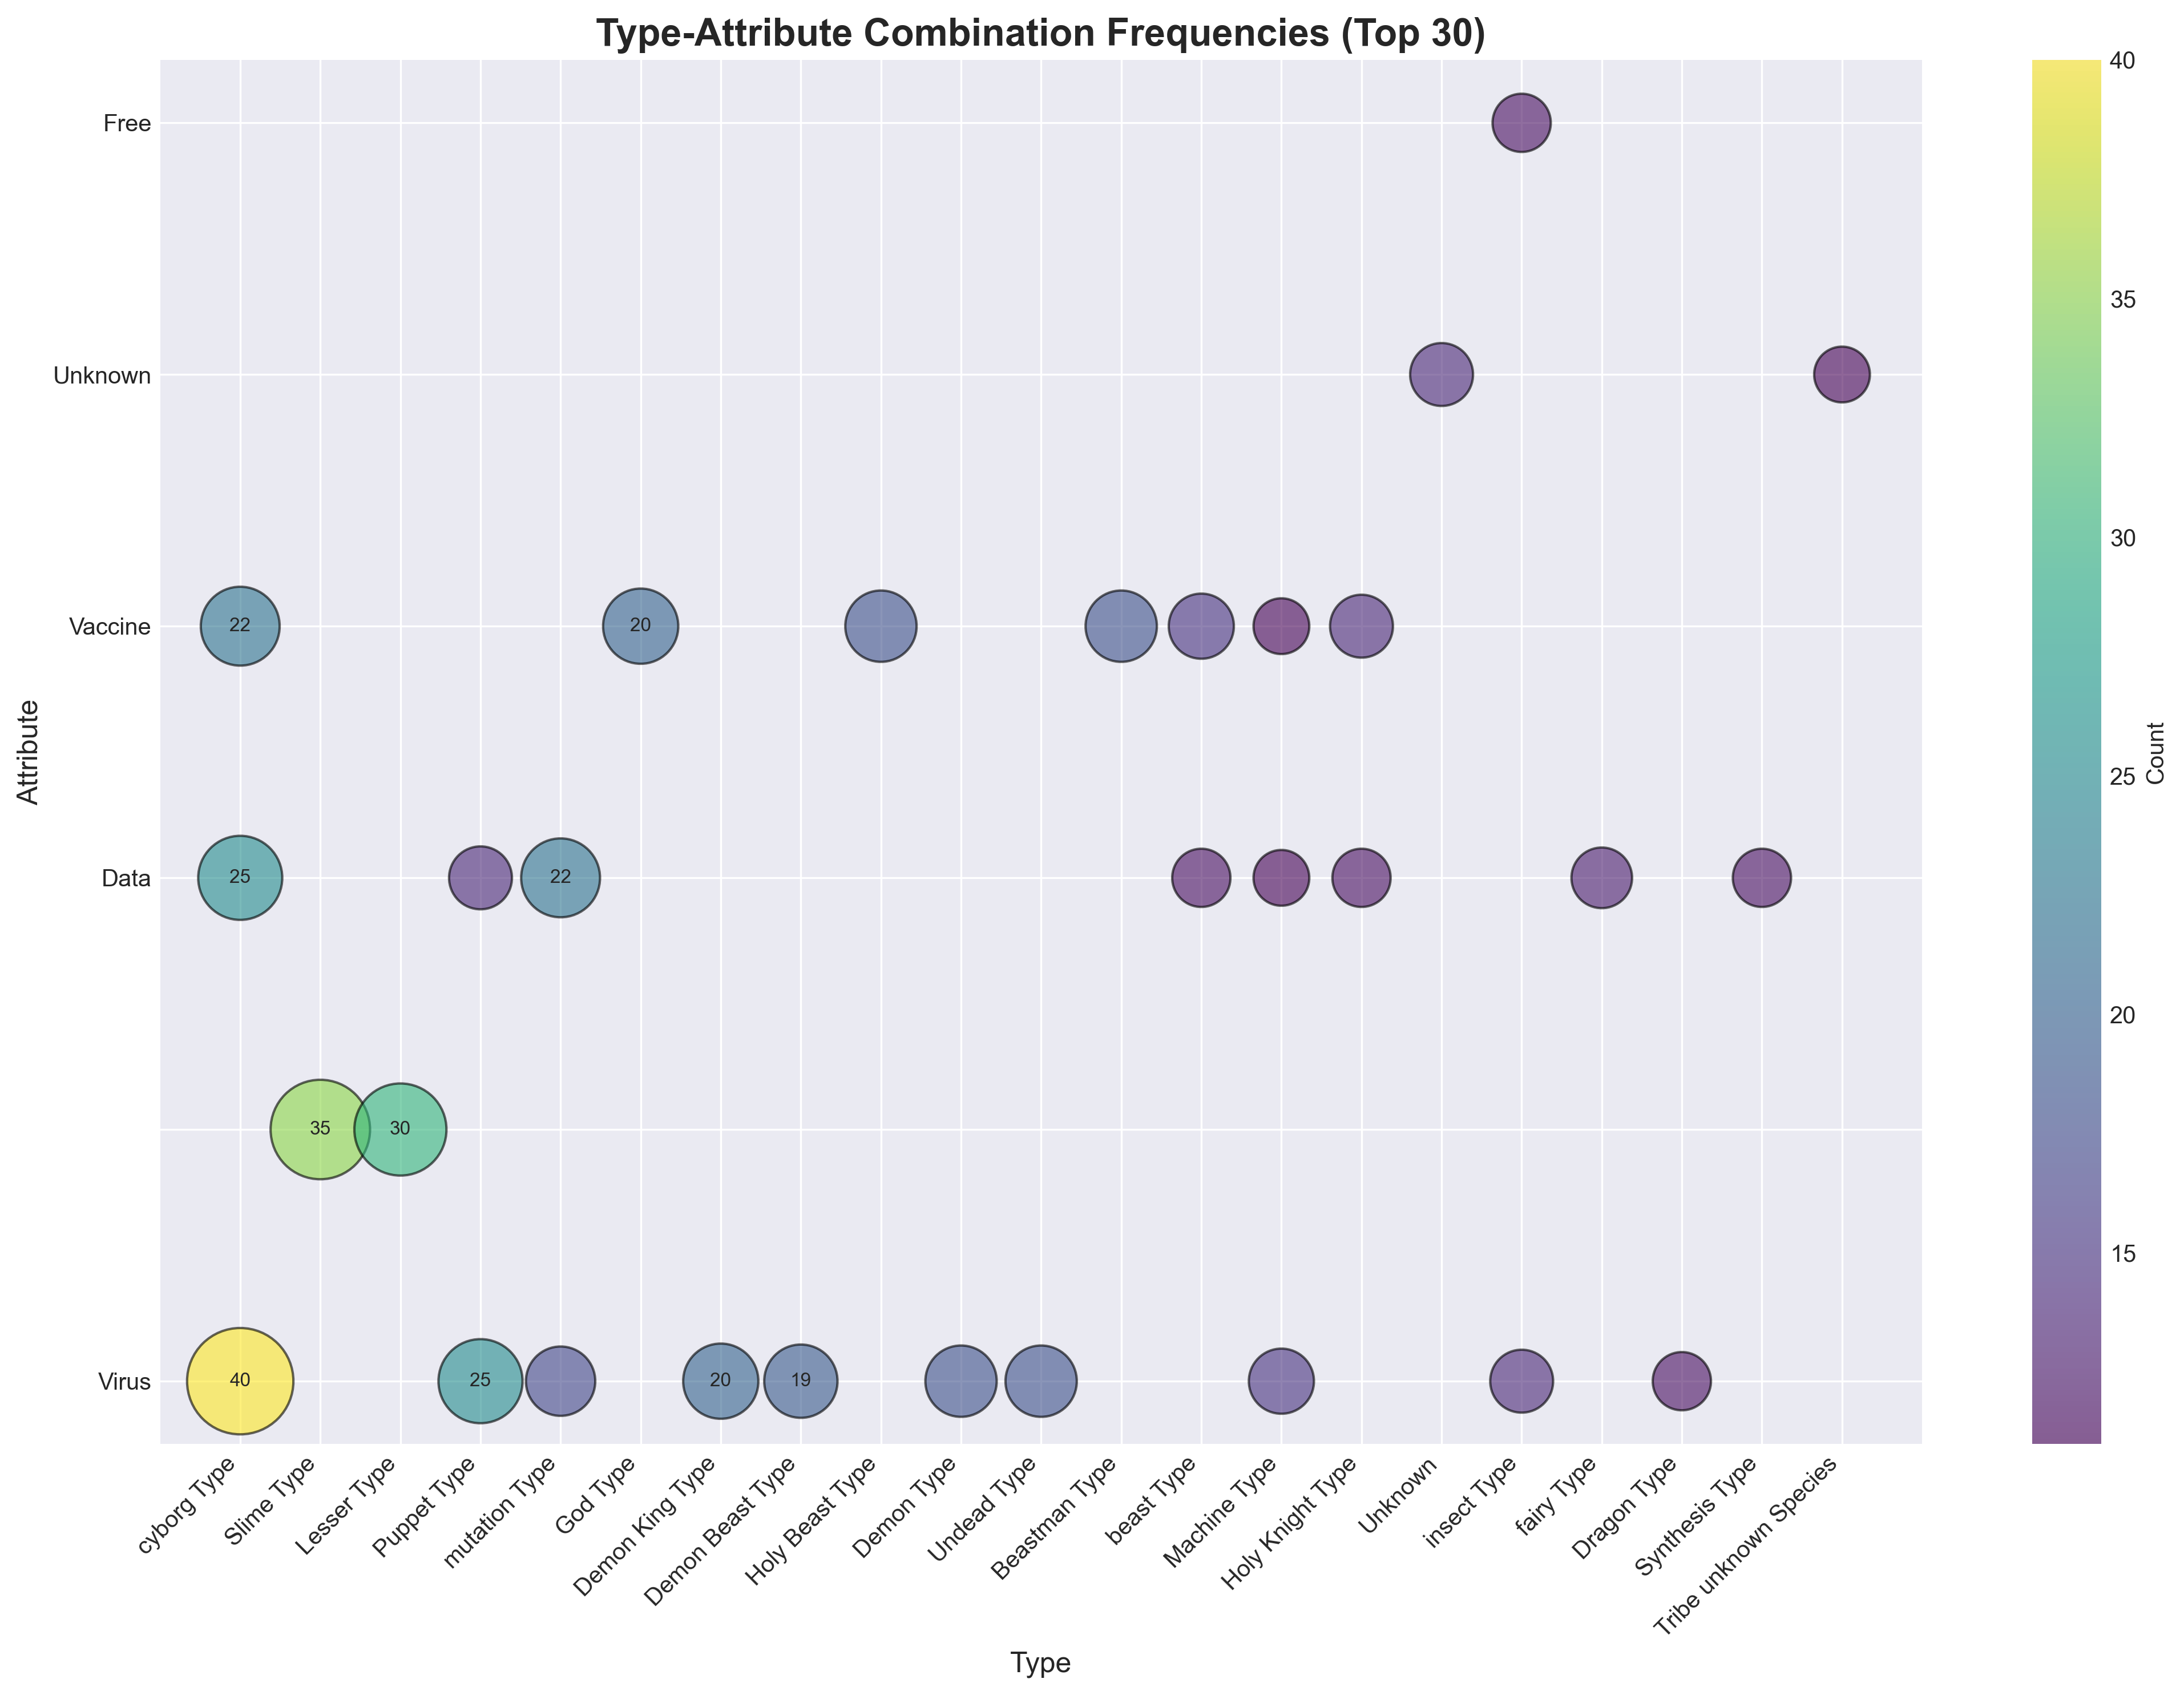

In [37]:
# Bubble chart for type-attribute combinations
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for bubble chart
top_combinations = type_attr_combinations.head(30)
types = top_combinations['type'].values
attributes = top_combinations['attribute'].values
counts = top_combinations['count'].values

# Create categorical positions
unique_types = list(dict.fromkeys(types))
unique_attrs = list(dict.fromkeys(attributes))
x_pos = [unique_types.index(t) for t in types]
y_pos = [unique_attrs.index(a) for a in attributes]

# Create bubble chart
scatter = ax.scatter(x_pos, y_pos, s=counts*50, alpha=0.6, 
                    c=counts, cmap='viridis', edgecolors='black', linewidth=1)

# Customize
ax.set_xticks(range(len(unique_types)))
ax.set_xticklabels(unique_types, rotation=45, ha='right')
ax.set_yticks(range(len(unique_attrs)))
ax.set_yticklabels(unique_attrs)
ax.set_xlabel('Type', fontsize=12)
ax.set_ylabel('Attribute', fontsize=12)
ax.set_title('Type-Attribute Combination Frequencies (Top 30)', fontsize=16, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Count', fontsize=10)

# Add count labels for largest bubbles
for i, count in enumerate(counts[:10]):
    ax.annotate(str(count), (x_pos[i], y_pos[i]), 
                ha='center', va='center', fontsize=8)

plt.tight_layout()
save_figure(fig, "type_attribute_bubble_chart", notebook_name=notebook_name)
plt.show()

Saved: ../results/03_type_attribute_correlation/figures/parallel_coordinates_attributes.png
Saved: ../results/03_type_attribute_correlation/figures/parallel_coordinates_attributes.svg
Saved: ../results/03_type_attribute_correlation/figures/parallel_coordinates_attributes.pdf


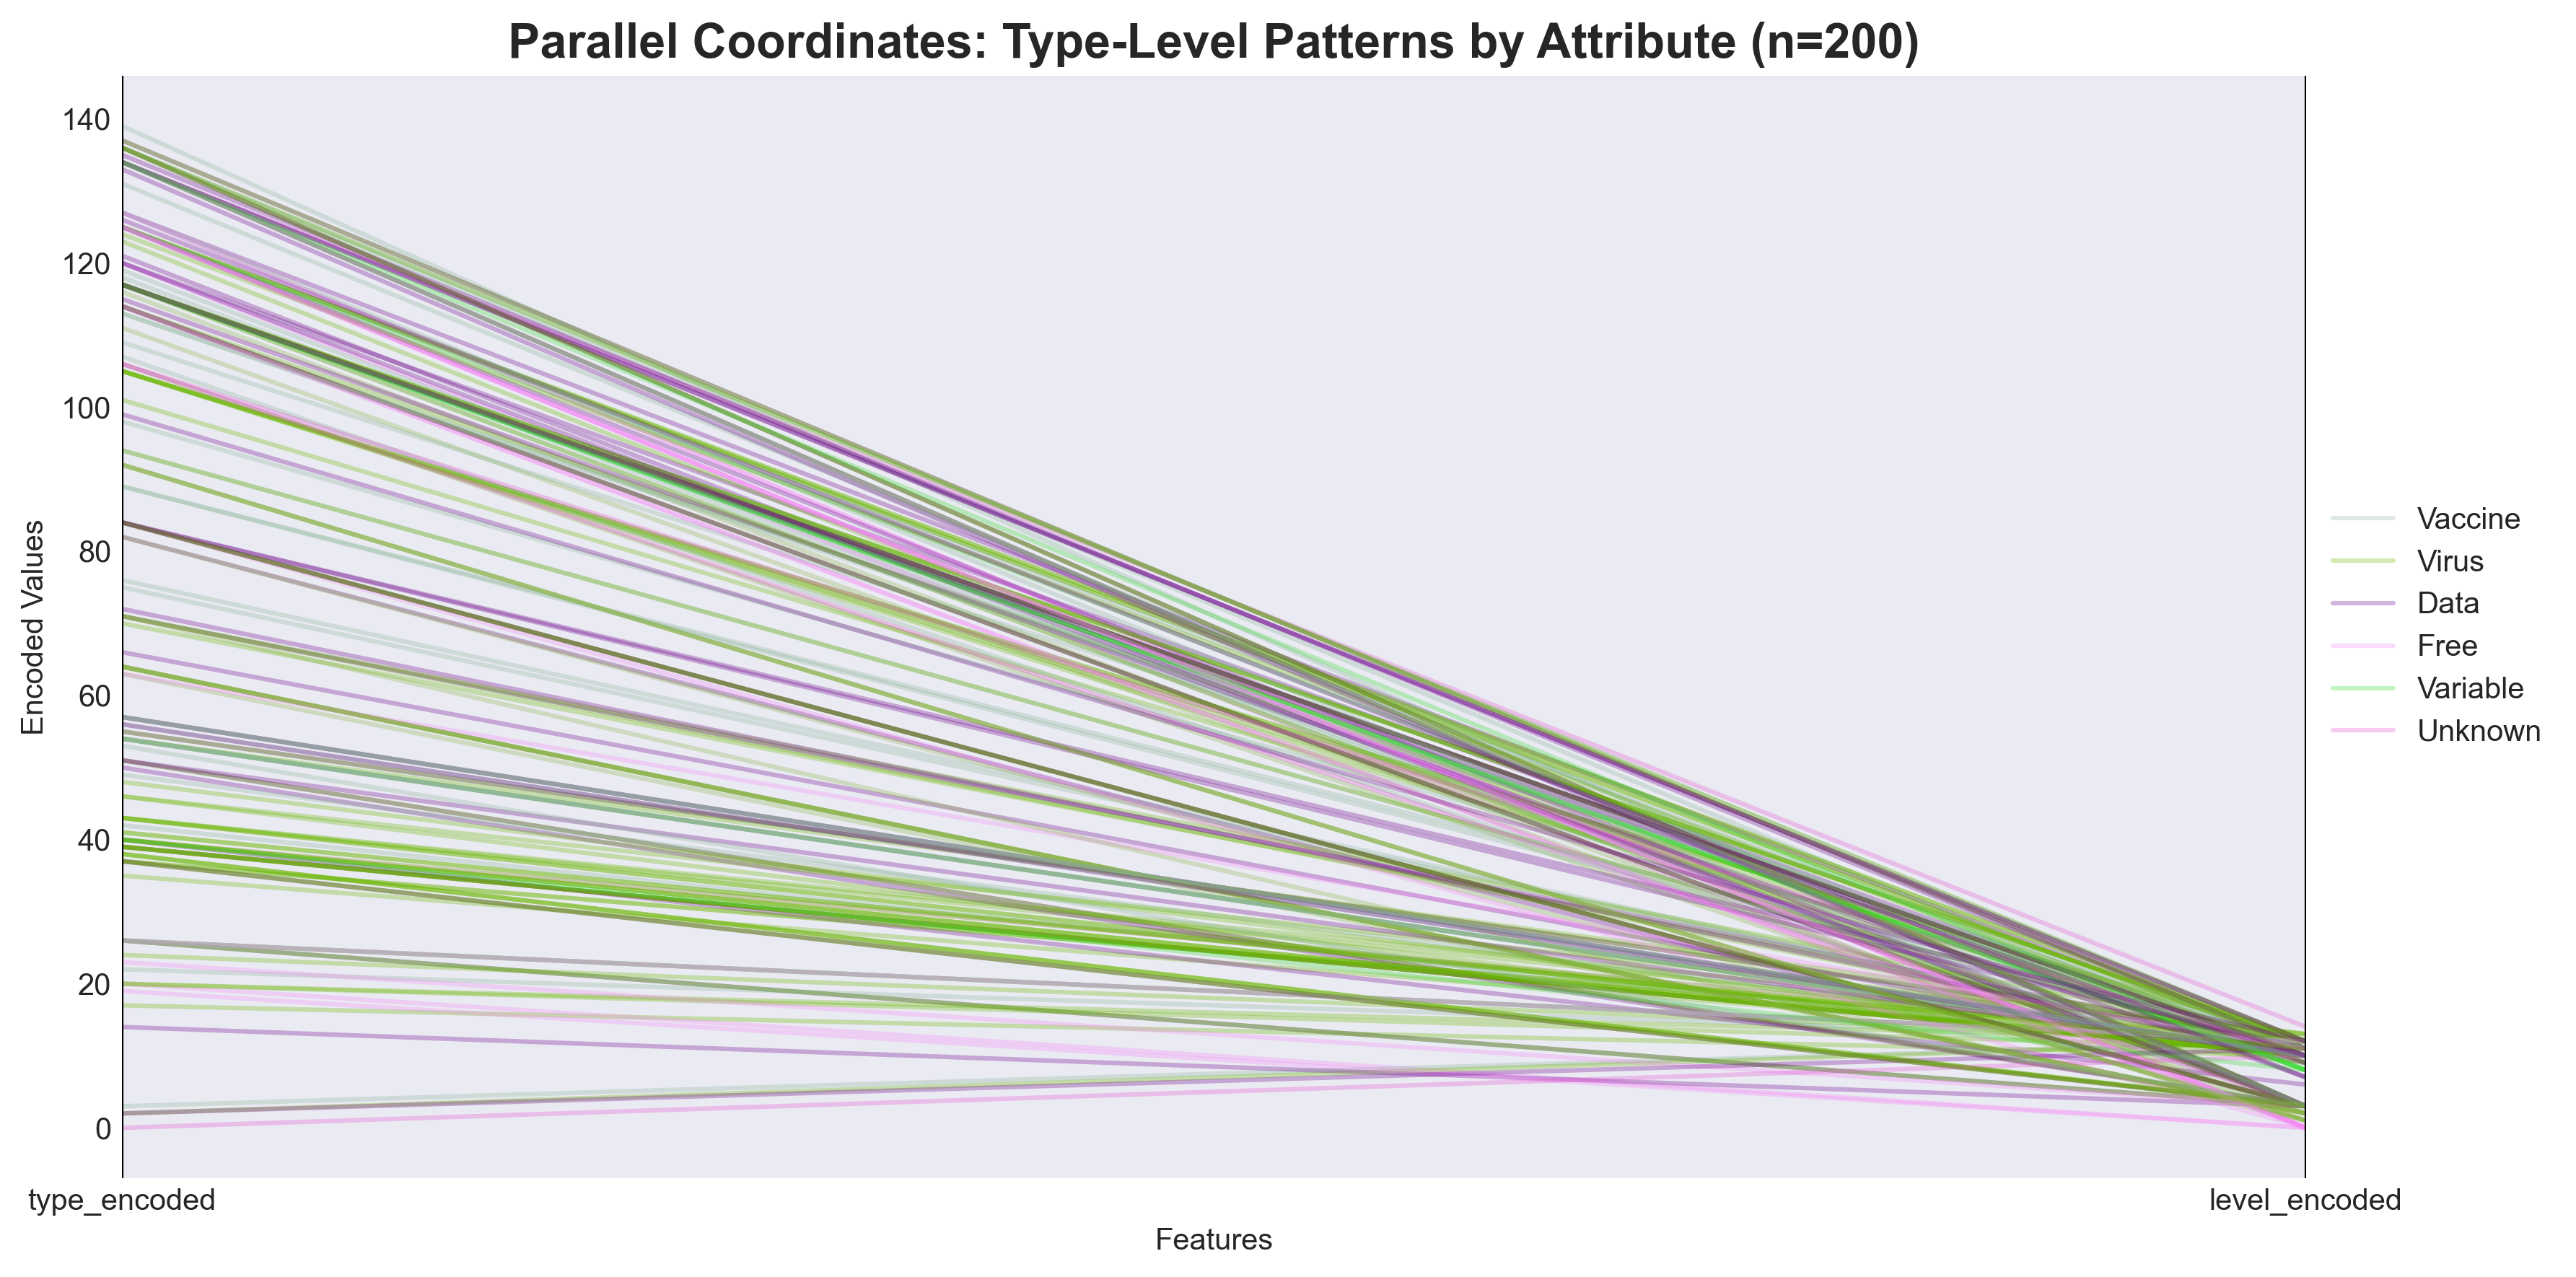

In [38]:
# Parallel coordinates plot for multi-attribute patterns
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
sample_size = 200
parallel_data = complete_df[['type', 'attribute', 'level']].copy()

# Encode categoricals as numbers for visualization
for col in ['type', 'attribute', 'level']:
    le = LabelEncoder()
    parallel_data[f'{col}_encoded'] = le.fit_transform(parallel_data[col])

# Sample data
if len(parallel_data) > sample_size:
    parallel_data = parallel_data.sample(n=sample_size, random_state=42)

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
parallel_coordinates(parallel_data[['attribute', 'type_encoded', 'level_encoded']], 
                    'attribute', alpha=0.3, ax=ax)

ax.set_xlabel('Features')
ax.set_ylabel('Encoded Values')
ax.set_title(f'Parallel Coordinates: Type-Level Patterns by Attribute (n={sample_size})', 
            fontsize=16, fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
save_figure(fig, "parallel_coordinates_attributes", notebook_name=notebook_name)
plt.show()

In [39]:
# Statistical test results visualization
if len(level_assoc_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # P-values by level
    bars1 = ax1.bar(level_assoc_df['level'], -np.log10(level_assoc_df['p_value']), 
                    color=[LEVEL_COLORS.get(l, '#808080') for l in level_assoc_df['level']])
    ax1.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
    ax1.set_xlabel('Level')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('Type-Attribute Association Significance by Level', fontsize=14)
    ax1.legend()
    
    # Effect sizes by level
    bars2 = ax2.bar(level_assoc_df['level'], level_assoc_df['cramers_v'], 
                    color=[LEVEL_COLORS.get(l, '#808080') for l in level_assoc_df['level']])
    ax2.set_xlabel('Level')
    ax2.set_ylabel("Cramér's V")
    ax2.set_title('Type-Attribute Association Strength by Level', fontsize=14)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax = bar.axes
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    save_figure(fig, "level_association_statistics", notebook_name=notebook_name)
    plt.show()

## 8. Export Results

In [40]:
# Create results directory
from pathlib import Path
results_dir = Path(f'../results/{notebook_name}/data')
results_dir.mkdir(parents=True, exist_ok=True)

# Export key findings
correlation_results = {
    'chi_square_statistic': float(chi2),
    'p_value': float(p_value),
    'cramers_v': float(cramers_v_value),
    'mutual_information': float(mi_score),
    'normalized_mi': float(nmi_score),
    'n_unique_combinations': len(type_attr_combinations),
    'n_rare_combinations': len(rare_combinations)
}

import json
with open(results_dir / 'type_attribute_correlations.json', 'w') as f:
    json.dump(correlation_results, f, indent=2)

# Export combination frequencies
type_attr_combinations.to_csv(results_dir / 'type_attribute_combinations.csv', index=False)

# Export association rules if generated
if 'rules' in locals() and len(rules) > 0:
    rules_export = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
    rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))
    rules_export.to_csv(results_dir / 'association_rules.csv', index=False)

# Export frequent itemsets
if len(frequent_itemsets) > 0:
    itemsets_export = frequent_itemsets.copy()
    itemsets_export['itemsets'] = itemsets_export['itemsets'].apply(lambda x: ', '.join(list(x)))
    itemsets_export.to_csv(results_dir / 'frequent_itemsets.csv', index=False)

print("Results exported successfully!")

Results exported successfully!


## Summary and Key Findings

### Type-Attribute Correlation Insights:

1. **Statistical Dependence**:
   - Strong statistical evidence that type and attribute are not independent
   - Effect size suggests meaningful associations between certain types and attributes
   - Mutual information confirms information gain from knowing one feature

2. **Distribution Patterns**:
   - Some type-attribute combinations are much more common than others
   - Many rare/unique combinations exist, suggesting diversity
   - Level influences the strength of type-attribute associations

3. **Association Rules**:
   - Strong predictive rules exist between certain features
   - Some combinations have high confidence and lift values
   - Patterns suggest design principles in Digimon creation

4. **Predictability**:
   - Attributes show moderate predictability from types
   - Types cluster into groups based on attribute preferences
   - Certain type families share similar attribute distributions

These findings reveal systematic patterns in how Digimon types and attributes are related, suggesting underlying design principles in the franchise.

In [41]:
# Close database connection
conn.close()
print("Type-Attribute correlation analysis complete! Database connection closed.")

Type-Attribute correlation analysis complete! Database connection closed.
